In [1]:
import matplotlib.pyplot as plt
import colorcet
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.postprocess import CmosReflectance
from pyeosim.spectral import Sentinel2VNIR
from pyeosim.sensor import TeledyneCMOS
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
rgb_image = rgb(im.isel(band=[70,40,20]), return_array=True)
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))

In [100]:
cmos = TeledyneCMOS(store_steps=True,
                    TDI_rows=32,
                    lens_diameter=.25,
                    pix_per_row=8196,
                    sense_node_gain=50,
                    adc_vref=1.6,
                    dark_current=570/32
                   )
demo = cmos.fit_transform(TOA)
# cmos.get_params()

Text(0.5, 0, 'Wavelength (nm)')

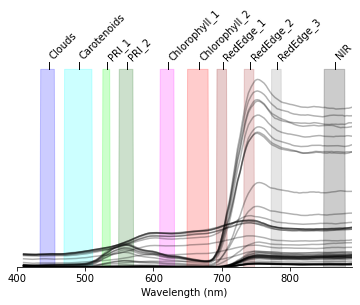

In [101]:
srf = cmos.spectral_response
ymax = .75
band_cols = ['blue', 'aqua', 'lime', 'darkgreen', 'magenta', 'red', 'darkred','brown','grey', 'k']
for n, c in zip(srf.band_names, band_cols):
#     srf.srfs[n].plot(c=c, label=n,)
    plt.fill_between(x=srf.srfs[n].wavelength, y1=srf.srfs[n].values*ymax,color=c, alpha=.2)
plt.ylim(.01,ymax*1.1)
plt.xlim(400,890)
# plt.legend()

for wlen, name in zip(srf.band_wavelengths.values(), srf.band_names):
    plt.annotate(name, (wlen,ymax*1.05), rotation=45)
    plt.annotate('I', (wlen,ymax*1), rotation=0)

im_ref.isel(y=200, x=slice(30,80)).plot(hue='x', c='k', alpha=.3, add_legend=False,)
plt.title('')
sns.despine(left=True)
plt.yticks([])
plt.ylabel('')
plt.xlim(400,890)
plt.xlabel('Wavelength (nm)')

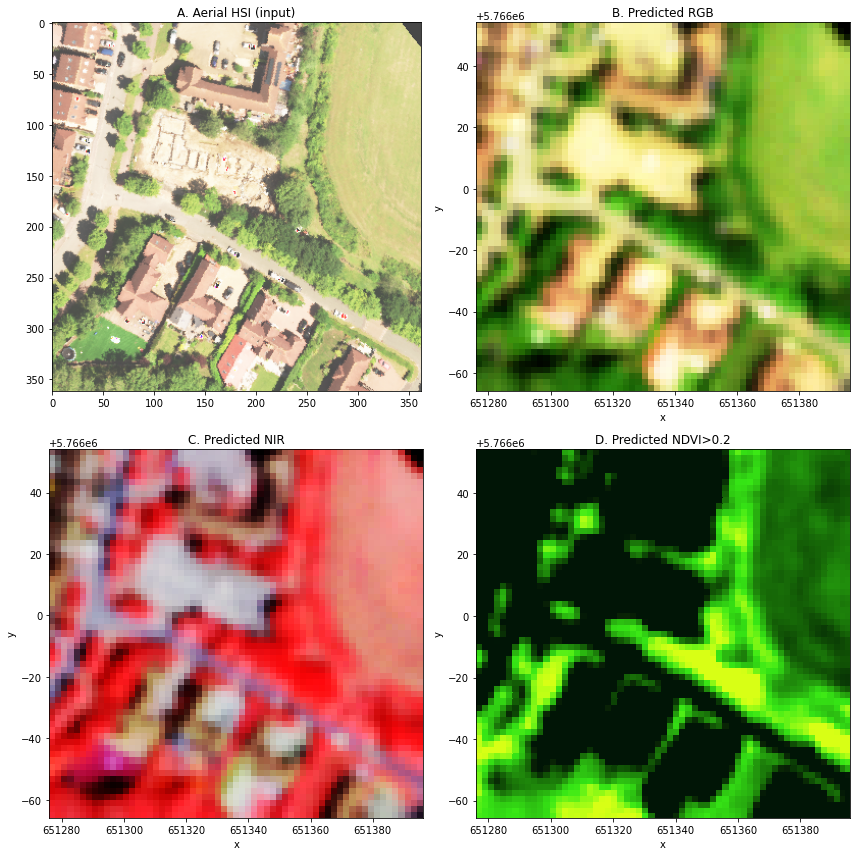

In [102]:
cmos_pipe = CmosReflectance(cmos, TOA_ref)
cmos_pipe.fit(TOA)
BOA = cmos_pipe.transform(TOA)
# # write latex table of parameters
cmos.steps_to_latex('outputs/cmos.tex')
# # generate reference and signal arrays
# calculate some composites
bgr = BOA.isel(band=[5,3,0]) * [.4,.7,1]
nir = BOA.isel(band=[9,6,3])
ndvi = ((BOA.isel(band=9) - BOA.isel(band=5))/(BOA.isel(band=9) + BOA.isel(band=5)))
# plot
fig, ax = plt.subplots(2,2, figsize=(12,12))

ax[0][0].imshow(rgb_image)
ax[0][0].set_title('A. Aerial HSI (input)')

rgb(bgr,ax=ax[0][1])
ax[0][1].set_title('B. Predicted RGB')

rgb(nir,ax=ax[1][0])
ax[1][0].set_title('C. Predicted NIR')

ndvi.plot(ax=ax[1][1], add_colorbar=False, vmin=.1, robust=True, cmap=colorcet.cm.kgy)
ax[1][1].set_title('D. Predicted NDVI>0.2')
plt.tight_layout()
plt.savefig('outputs/TreeView_example_1.png',dpi=200)

/Users/joe/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bmy"))
  
/Users/joe/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bmy"))
  This is separate from the ipykernel package so we can avoid doing imports until


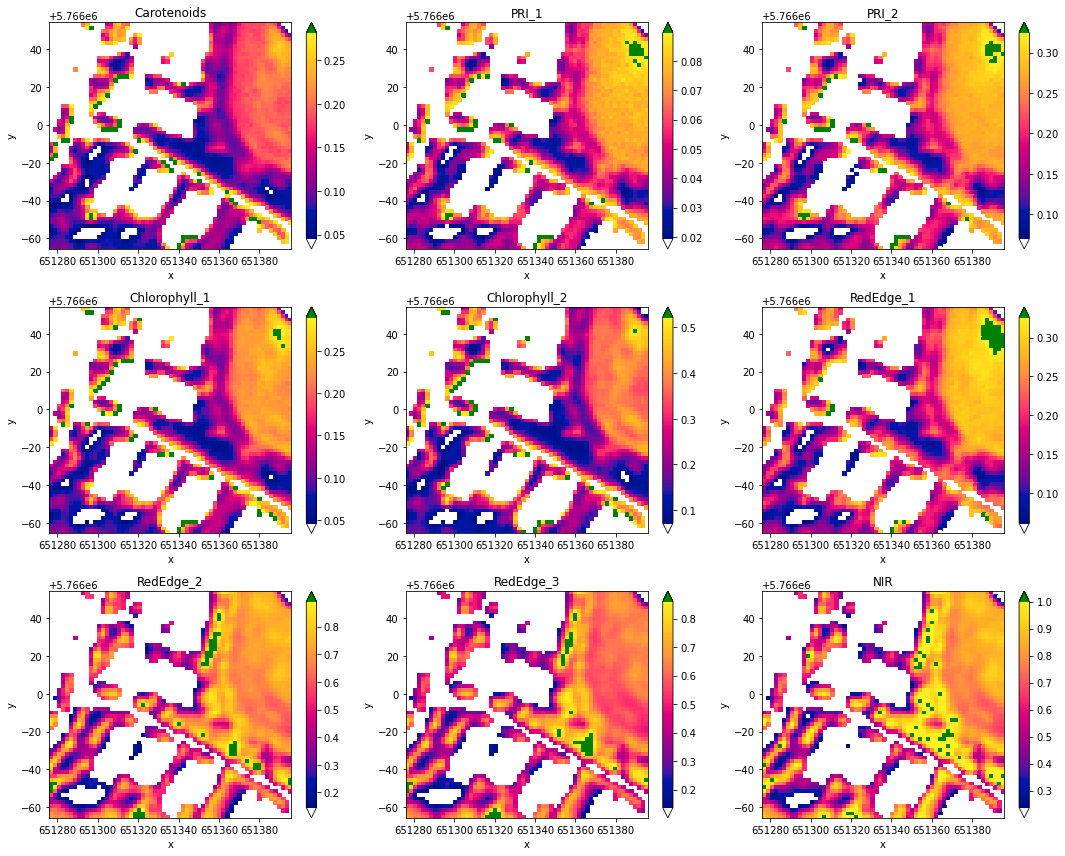

In [104]:
cmap_kgy = colorcet.cm.bmy
cmap_kgy.set_over('green')
cmap_kgy.set_under('w')
idx = 9
fig, ax = plt.subplots(3,3, figsize=(15,12))
ax = np.ravel(ax)
for i in range(1,10):
    BOA.where(ndvi>0).isel(band=i).plot(cmap=cmap_kgy, robust=True, ax=ax[i-1], )
    ax[i-1].set_title('{}'.format(BOA.band_name[i].values))
plt.tight_layout()
# plt.savefig('outputs/TreeView_example_1_plant.png',dpi=200)

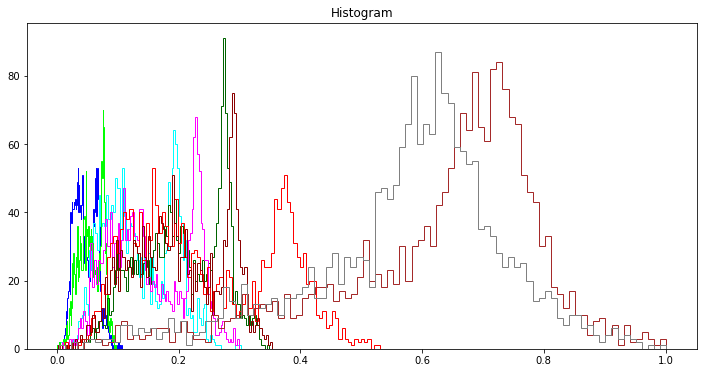

In [105]:
plt.figure(figsize=(12,6))
for i in range(9):
    BOA.isel(band=i).where(ndvi>.2).plot.hist(bins=100,histtype='step', color=band_cols[i])